# Sprint 12 - Project description

The Model Fitness gym chain is developing a customer interaction strategy based on analytical data. 

One of the most common problems that gymns and other services face is the client churn. How do you know if a client is not with you anymore? I can calculate the churn based on people getting rid of their accounts or not renewing their contracts. However, sometimes it is not obvious that a client has left, they sneak out. 

Turnover indicators vary from area to area. If an user rarely buys from an online store but in a regular basis, you can't say he is a runner. But, if for two weeks they did not open the channel that is updated daily, that is a reason to worry: your follower may have gotten bored and left you.

For a gym, makes sense to say that the clients had left if they disappeard for a month. Of course, it is possible that they are in Cancun and will come back to the gym when they return, but this is not a common situation. Normaly if a client joins, comes a couple times then disappear, he probably won't come back.

Instead of fighting churn rates, Model Fitness digitalized part of their clients profile. My job is to analyse this information and come up with a retention strategy.

To do so I must:

- learn to predict the churn probability (for the next month) for each client.
- Draw up profiles of typical users: select the most striking groups and describe their main characteristics
- Analyse the factors that most impact the churn
- Take basic conclusions and develop recommendations about how to improve the clients service:
    - Identify target groups
    - suggest measurements to diminish churning
    - Describe any other patter that I might see regardint the interactions with clients

## Step 1 - Download and load the data

- Load the necessary libraries

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [72]:
#loading the dataset
gym_churn = pd.read_csv('dataset_12/gym_churn_us.csv')

## Step 2 - performe the EDA

#### 2.1 Info about the dataset

In [73]:
#getting the shape and first 5 rows of the dataset
print(gym_churn.shape)
print()
print(gym_churn.head(3))

(4000, 14)

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   

   Churn  
0      0  
1      0  
2      0  


In [74]:
print(gym_churn['Churn'].value_counts())

Churn
0    2939
1    1061
Name: count, dtype: int64


In [75]:
#getting the info about the data
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [101]:
print(gym_churn.describe())

            gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

Conclusion
- The dataset has 4000 entries and 14 columns, none of the columns has null values.
- I could change the columns so all of them would be in lowercase and it would be easier to work later

In [102]:
#transforming all columns to lowercase

new_col_names = []

for old_name in gym_churn.columns:
    name_lowered = old_name.lower()
    new_col_names.append(name_lowered)

#replacing the old names for the new ones
    
gym_churn.columns = new_col_names

In [103]:
#filtering the data for the  clients that did or did not churn

not_churned = gym_churn[gym_churn['churn']==0].drop('churn', axis=1)
churned = gym_churn[gym_churn['churn']==1].drop('churn', axis=1)

In [104]:
#describing the data from the clients that did not churn
print(not_churned.describe())

            gender  near_location      partner  promo_friends        phone  \
count  2939.000000    2939.000000  2939.000000    2939.000000  2939.000000   
mean      0.510037       0.873086     0.534195       0.353522     0.903709   
std       0.499984       0.332933     0.498914       0.478144     0.295040   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     1.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      2939.000000   2939.000000  2939.000000   
mean          5.747193      0.464103    29.976523   
std           4.716942      0.498795     3.009933   
min           1.000000      0.000000    19.000000   
25%           1.000000      0.00

In [105]:
#describing the data from the clients that did churn
print(churned.describe())

            gender  near_location      partner  promo_friends        phone  \
count  1061.000000    1061.000000  1061.000000    1061.000000  1061.000000   
mean      0.510839       0.768143     0.355325       0.183789     0.902922   
std       0.500118       0.422217     0.478837       0.387495     0.296204   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       0.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      1061.000000   1061.000000  1061.000000   
mean          1.728558      0.268615    26.989632   
std           2.132371      0.443448     2.895163   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

- Differences between the data from clients that didn't or did churn
    - gender: well distributed between both cases.
    - near_location: better mean for the clients that did not churn, which means that they live nearer to the gym
    - partner: in average, the clients that did churn are usually not partners
    - promo_friends: we can se that in average we have a 0,18 rate of users that initially subscribed from a promo code, while the users that did not churn have a 0,35 rate.
    - phone: in both cases we can see a higher ratio of clients that provided their phone number to the gym
    - contract period: in average clients that churned have a smaller contract period of 1,72 months while clients that did not churn have a 5,74 months contract
    - group visits: clients that did churn have a smaller rate of participating in group_visits (0,26) in comparisson to the ones that did not churn (0,46)
    - age: in average clients that did churn are younger than clients that didn't
    - avg_additional_charges_total: clients that did churn usually spent less money in other services that the gym offers
    - month_to_end_contract: clients that did churn have less months to end their contract (1,66) than the ones that didn't (5,28)
    - lifetime: clients that did churn have a lower lifetime (0,99) compared to the ones that didn't (4,71), which means that they had gone to the gym for about a month before quiting.
    - avg_class_frequency_total: clients that did churn had less visits per week (1,47) to the gym, while the ones that didn't churn went to the gym about 2,02 times per week along all it's lifetime
    - avg_class_frequency_current_month: clients that did churn usually go 1,04 times per week to the gym, while the ones that didn't churn went around 2,02 times per week.

### 2.1.1 histograms - churned

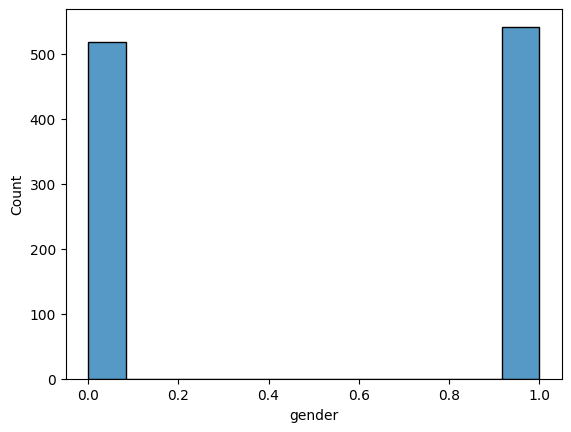

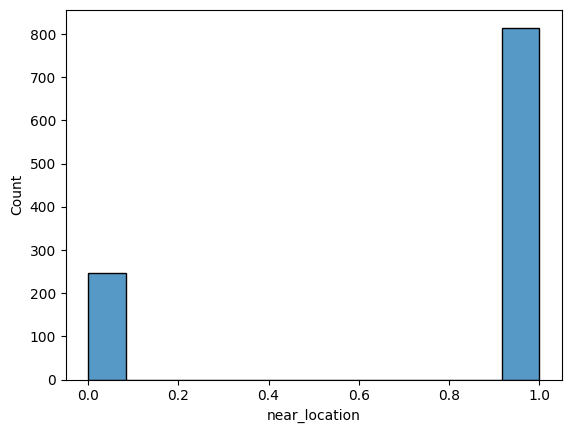

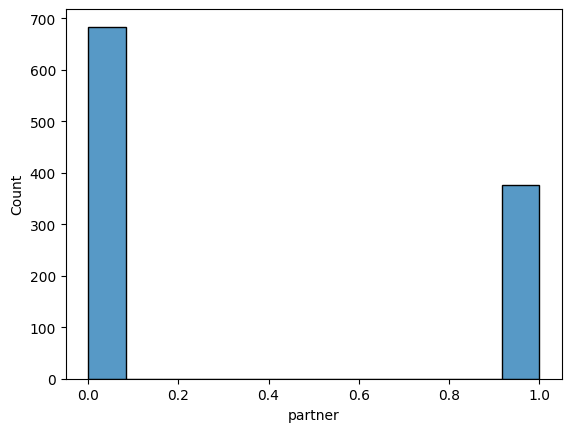

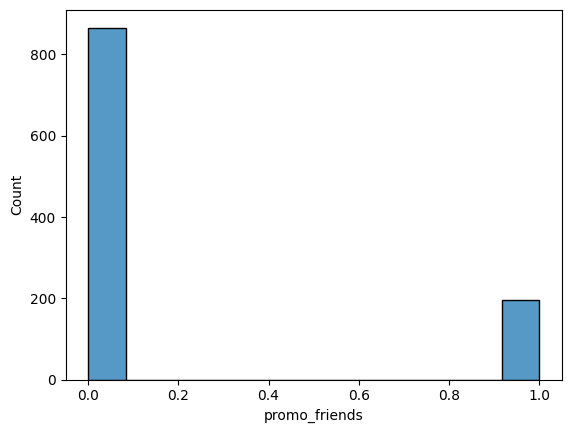

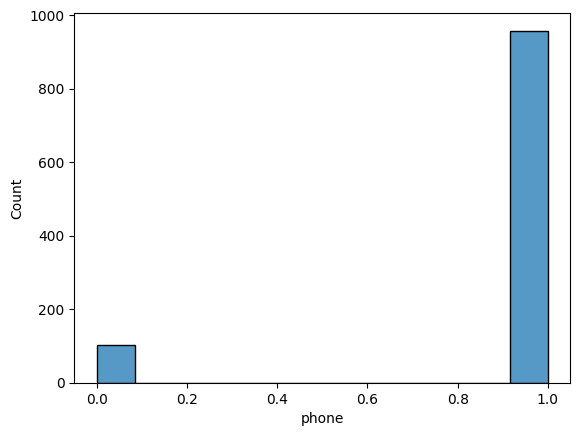

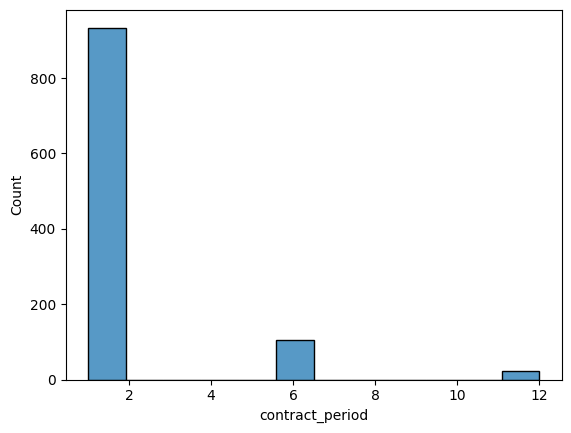

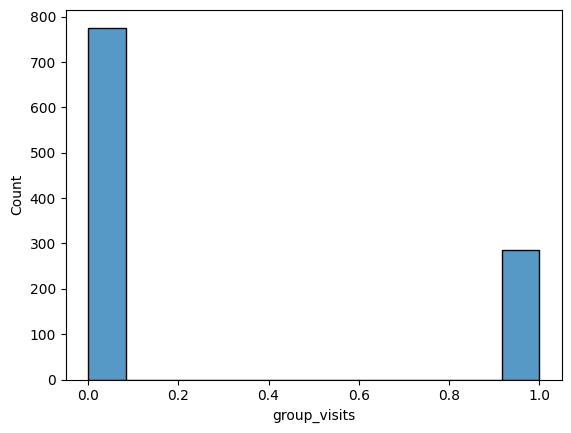

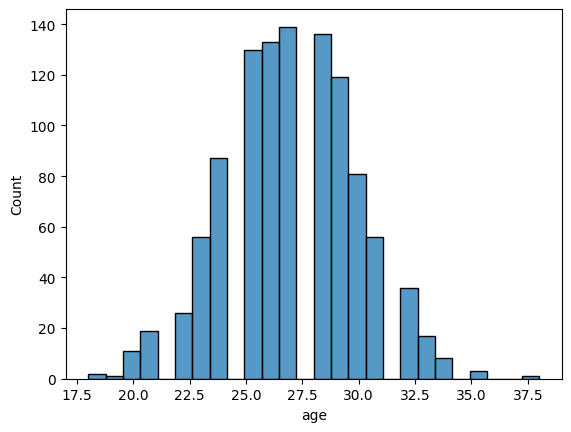

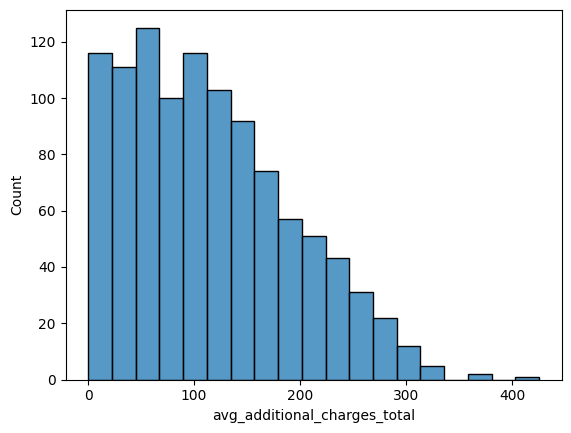

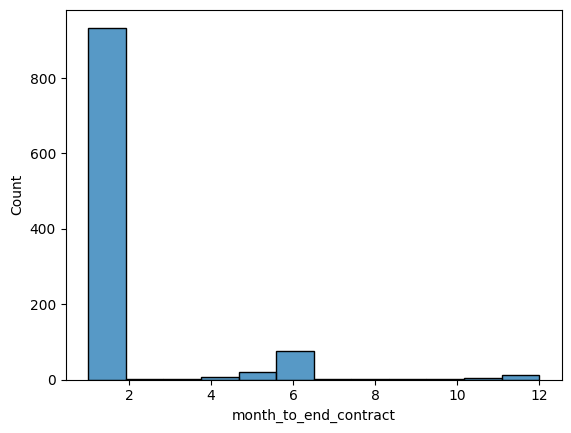

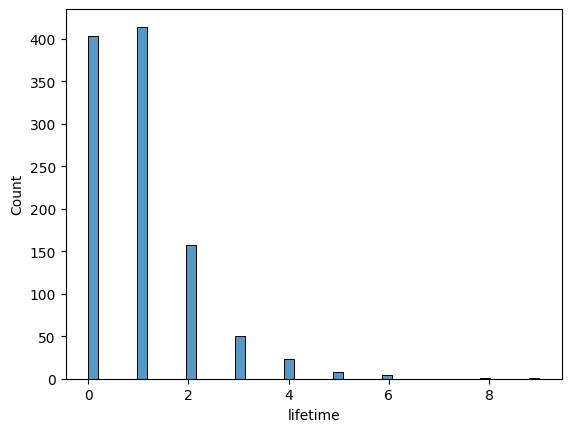

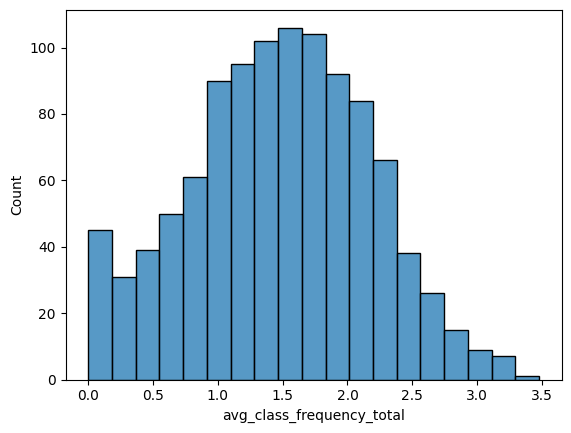

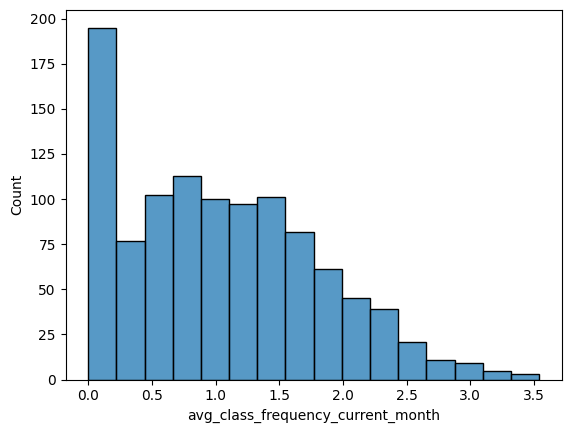

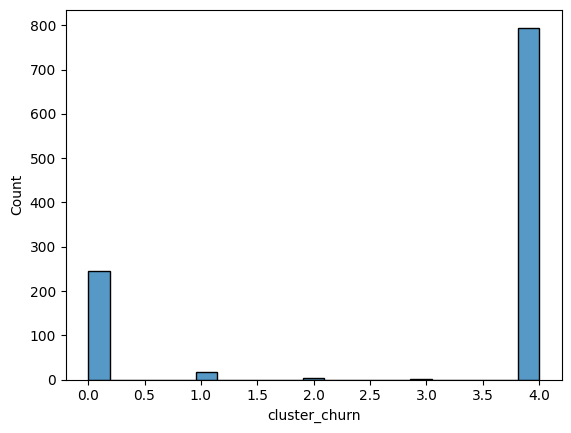

In [133]:
#building histograms - churned 

for col in churned:
    sns.histplot(x=churned[col])
    plt.show()

### 2.1.2 - not churned

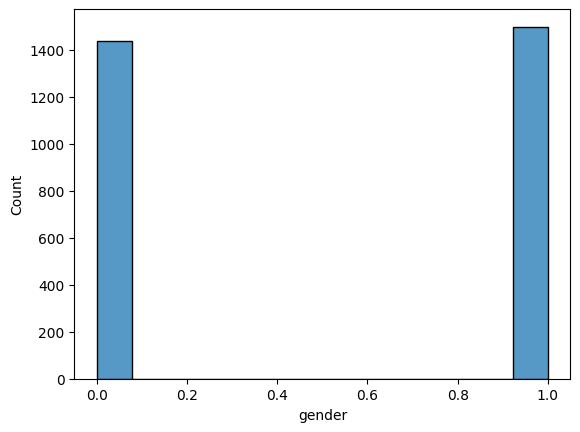

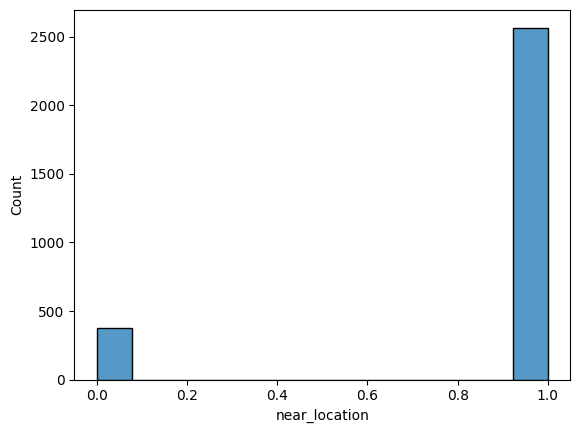

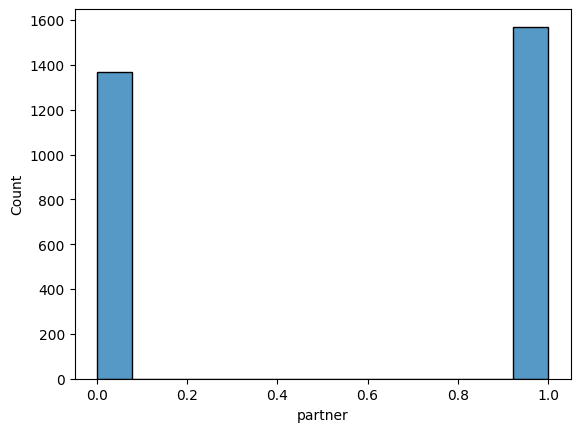

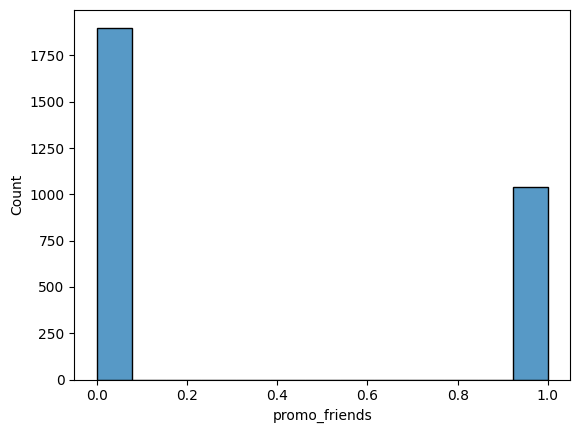

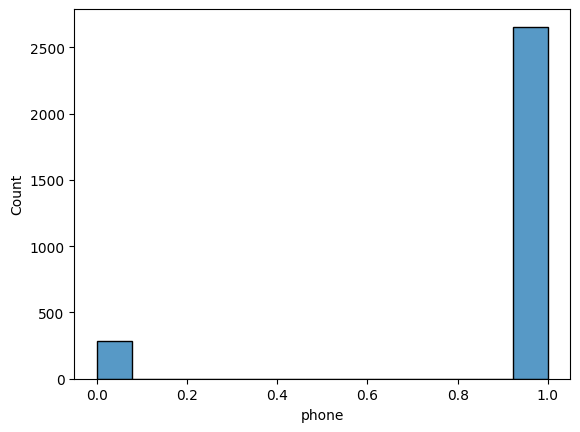

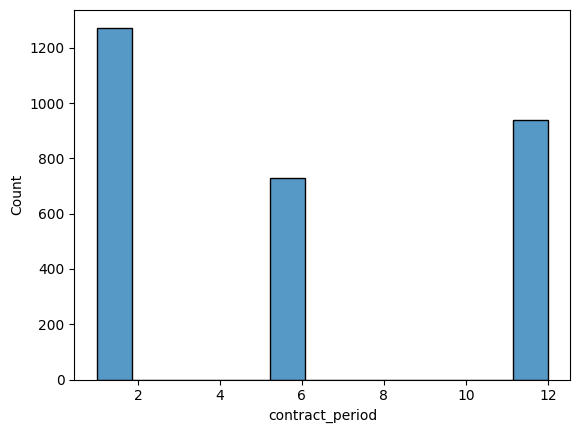

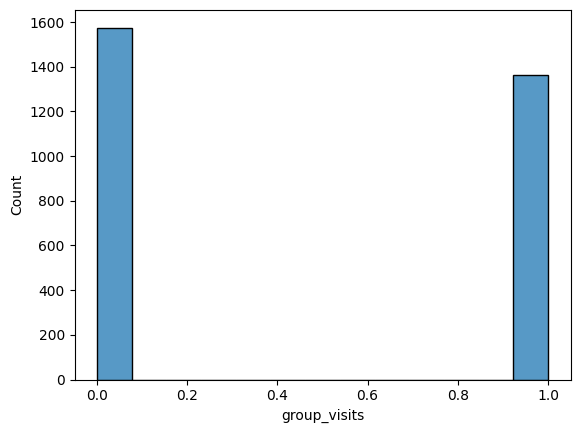

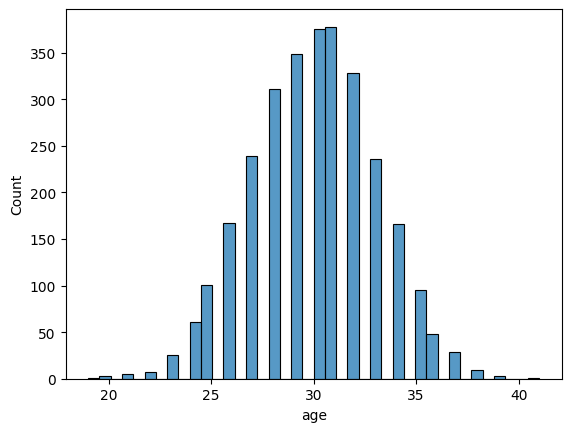

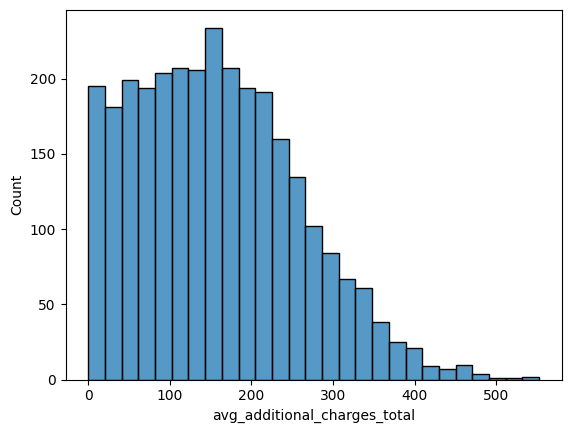

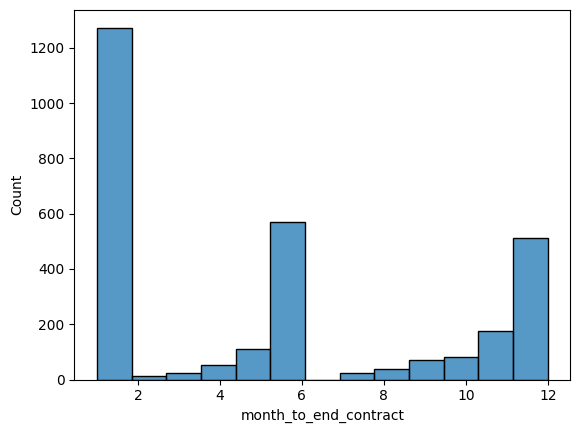

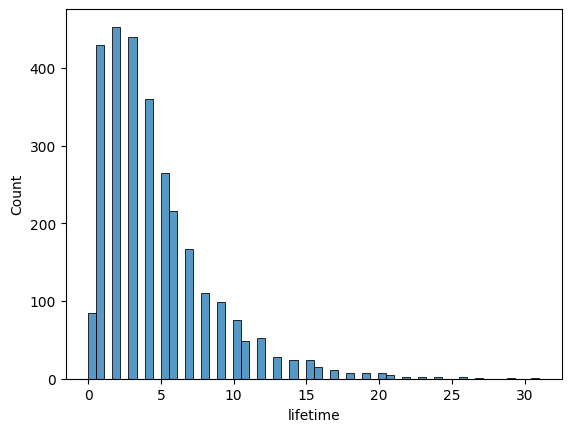

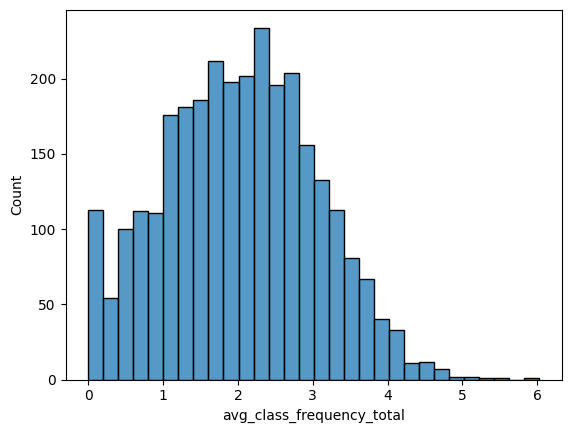

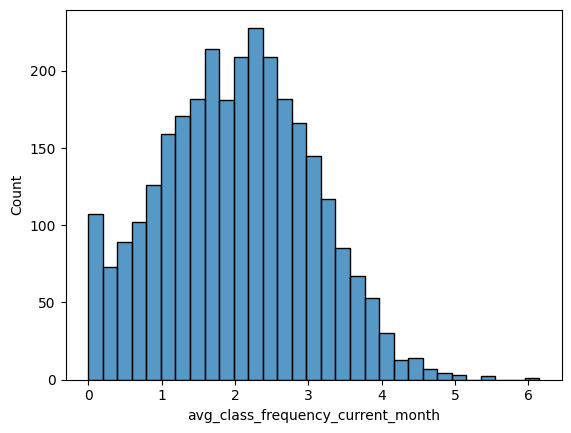

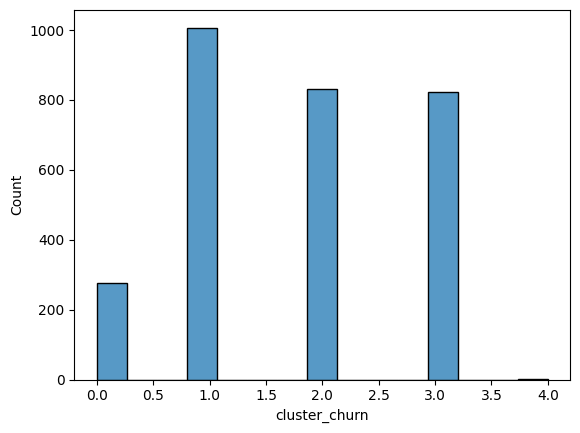

In [132]:
#building histograms - not churned 
for col in not_churned:
    sns.histplot(x=not_churned[col])
    plt.show()

- Conclusion
    - The histograms allow us to see some similarities to the data obtained by comparing the means of the variables from the clients that did or did not churn.

### 2.2 - correlation matrix

#### 2.2.1 Not churned

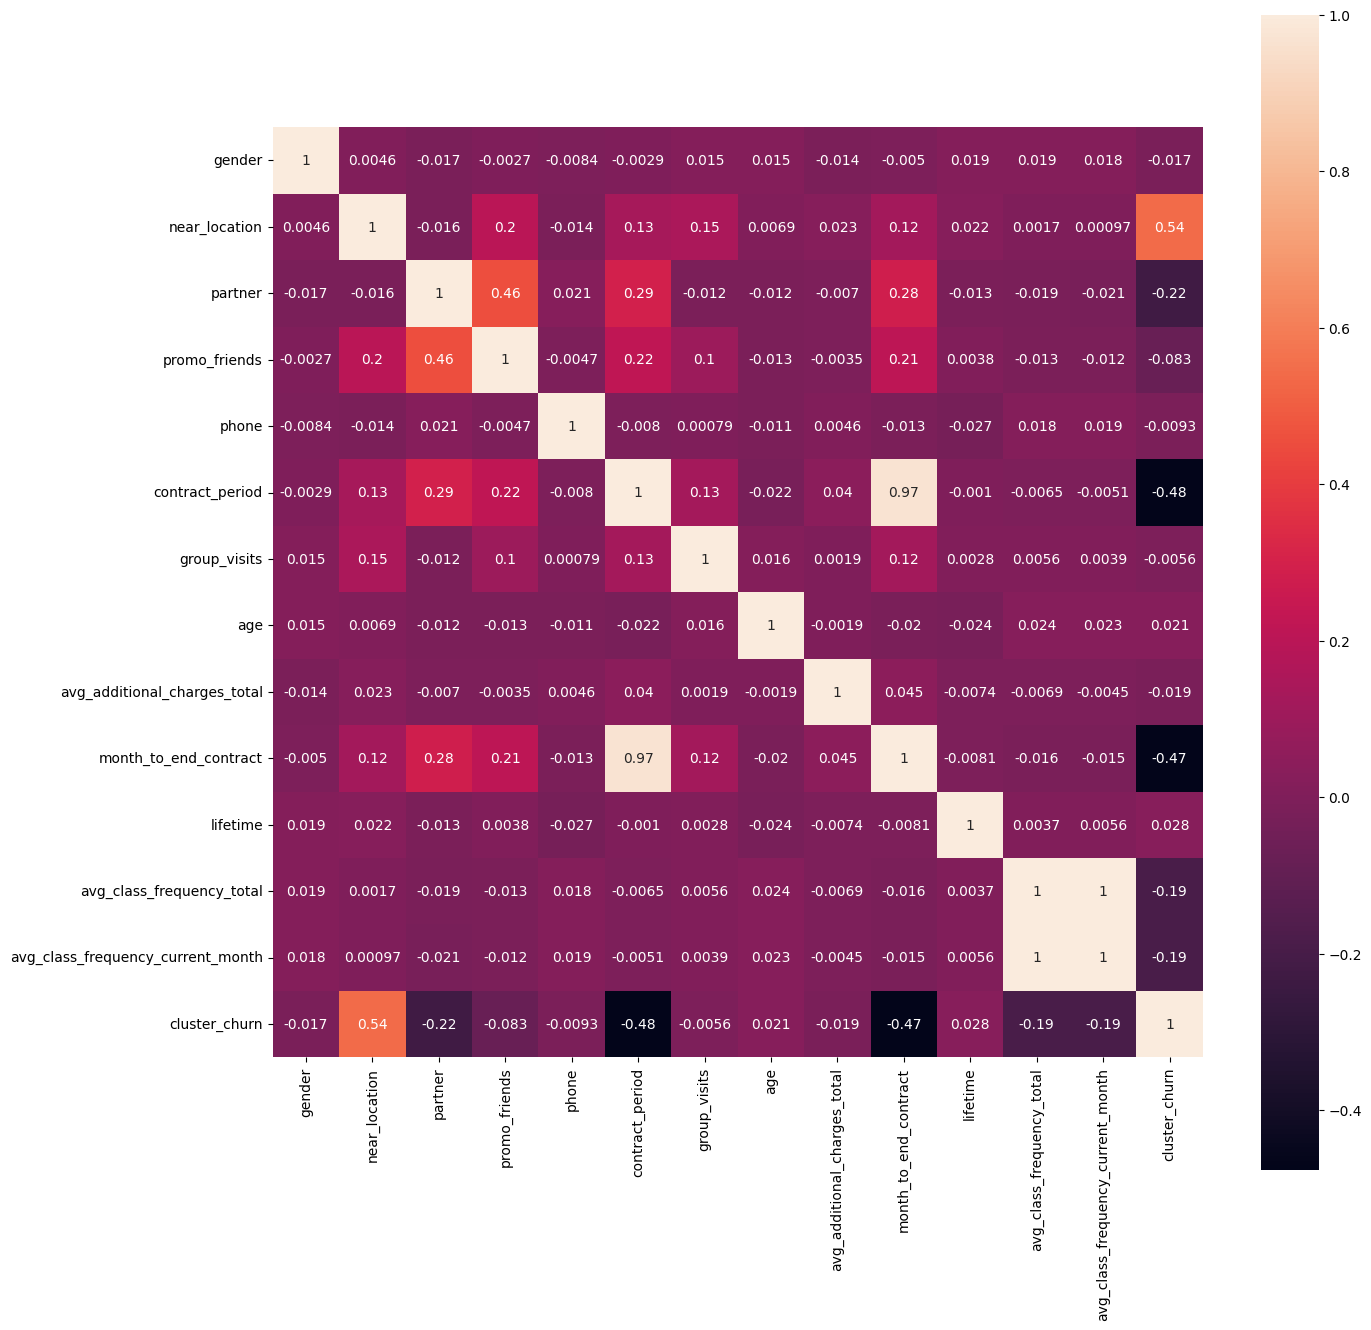

In [106]:
#buildig and rendering a correlation matrix for the not_churned clients
not_churned_cm = not_churned.corr()

#ploting a heatmap for the correlation matrix for the not_churned clients
plt.figure(figsize=[15,15])
sns.heatmap(not_churned_cm, annot=True, square=True)

plt.show()

#make diagrams of the characteristic-objective variable paired distribution for each characteristic

for col in gym_churn.drop(['churn','near_location','phone','group_visits'], axis=1).columns:
    sns.scatterplot(x=gym_churn[col], y=gym_churn['churn'])
    plt.show()

#### 2.2.2 Churned

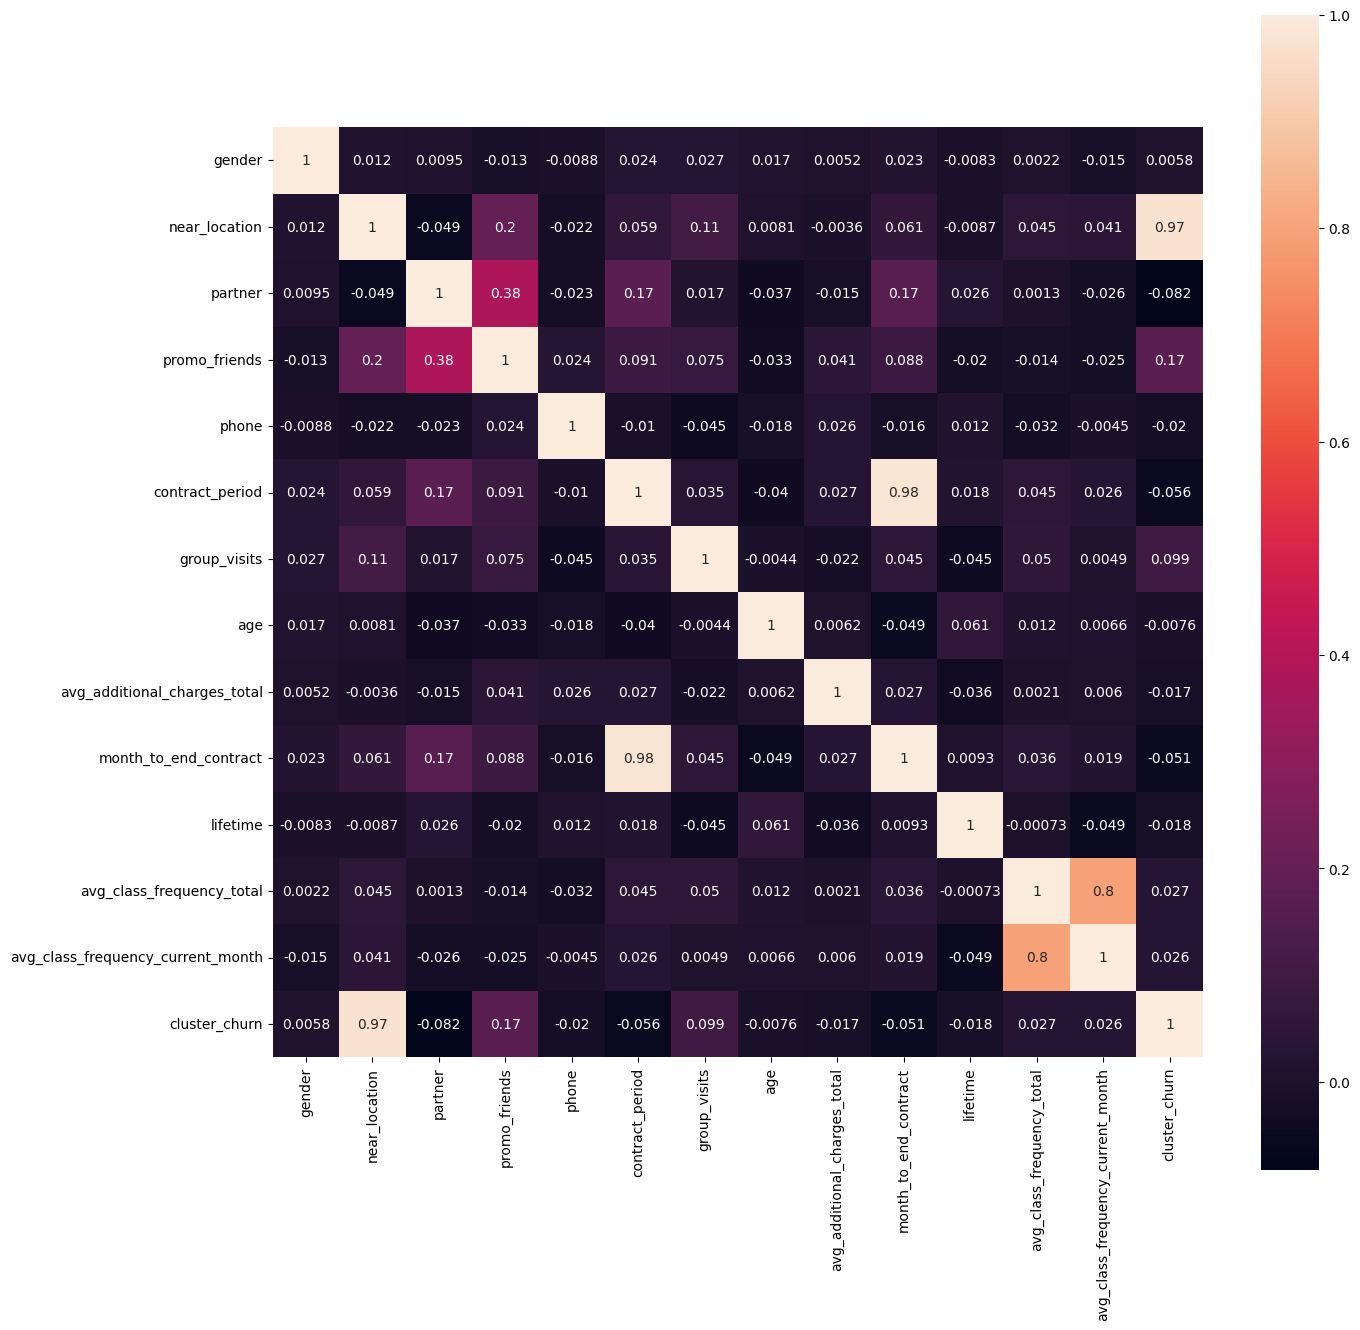

In [107]:
#buildig and rendering a correlation matrix for the churned clients
churned_cm = churned.corr()

#ploting a heatmap for the correlation matrix for the churned clients
plt.figure(figsize=[15,15])
sns.heatmap(churned_cm, annot=True, square=True)

plt.show()

#### 2.2.3 All data

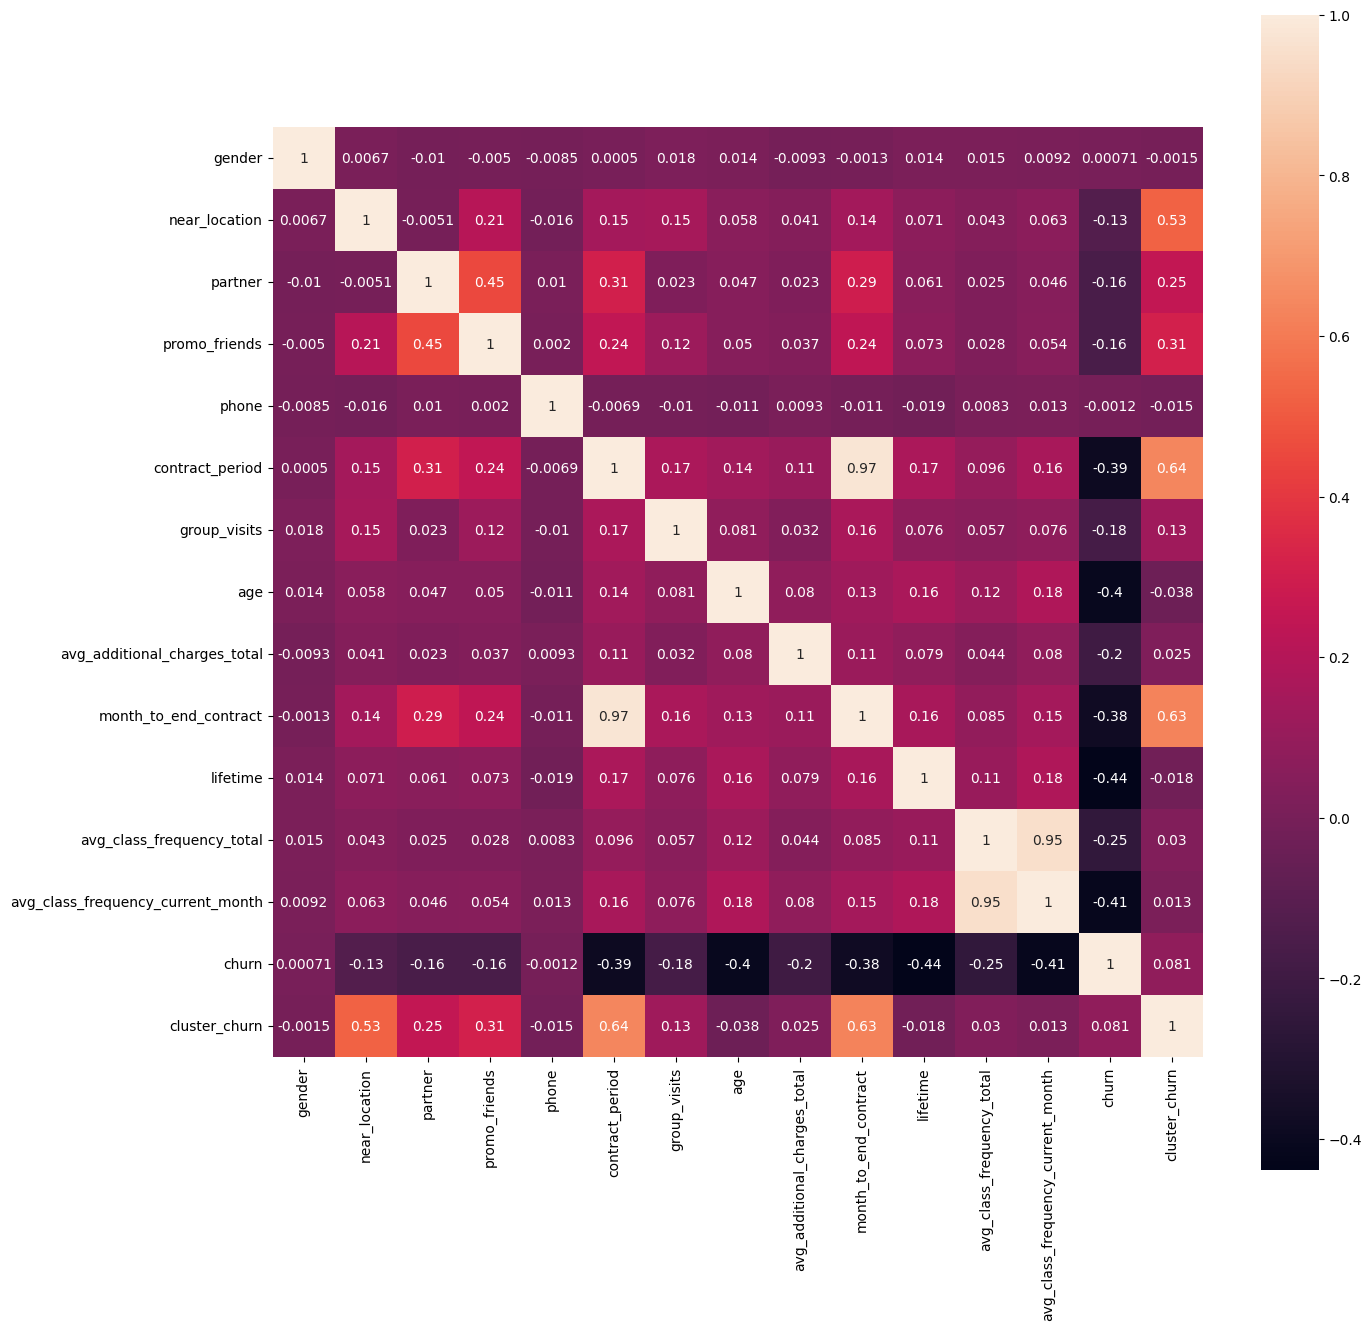

In [126]:
#buildig and rendering a correlation matrix for all the data
gym_churn_cm = gym_churn.corr()

#ploting a heatmap for the correlation matrix for all the data
plt.figure(figsize=[15,15])
sns.heatmap(gym_churn_cm, annot=True, square=True)

plt.show()

### Step 2 - Conclusion
- When analysing both cases for the data where the clients did (churned) or did not churn (not_churned), the correlation shows that form most cases the highest correlation values were not higher than 0,2 or a -0,1.
- When we analyse the correlation of the churn variable with all the variables it is possible to see that we have negative correlation values around -0,4 for contract_period, age, lifetime, month_to_end_contract and avg_class_frequency_total.

## Step 3 - build a model to predict customer churn

In [108]:
#dividing the dataset

X = gym_churn.drop(columns=['churn'])
y = gym_churn['churn']

#dividing the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [109]:
#training the StandardScaler with the training set 

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [110]:
#transforming the training and test sets

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [111]:
#defining the function do determine accuracy, precision, recall
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metric'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

### 3.1 training the model with logistic regression

In [112]:
#defining the model

lr_model = LogisticRegression(random_state=0)

#training the model
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [113]:
#using the model to make predictions

lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

#printing all metrics
print_all_metrics(y_test, lr_predictions,lr_probabilities, title= 'Metrics for the logistic regression')

Metrics for the logistic regression
	Accuracy: 0.97
	Precision: 0.93
	Recall: 0.93


### 3.2 training the model with random forest

In [114]:
#defining the forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

#training the model
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [115]:
#using the forest model to make predictions
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

#printing all metrics

print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for the random forest')

Metrics for the random forest
	Accuracy: 0.97
	Precision: 0.95
	Recall: 0.94


### 3.3 evaluating accuracy, precision and recall

- According to the results obtained from the logistic regression we obtained the following results:
    - Accuracy: 0.92
	- Precision: 0.85
	- Recall: 0.83

- As for the random forest predictions we obtained the following results:
    - Accuracy: 0.92
	- Precision: 0.84
	- Recall: 0.81

- This means that the logistic regression had better results than the random forest model to validate the data.

## Step 4 - Create customer groupings

In [116]:
#creating a StandardScaler object and applying it to train set
sc = StandardScaler()

#training the scaler and transforming the matrix for a train set
X_train_st = sc.fit_transform(X_train)

linked = linkage(X_train_st, method='ward')

#### 4.1 Dendrogram

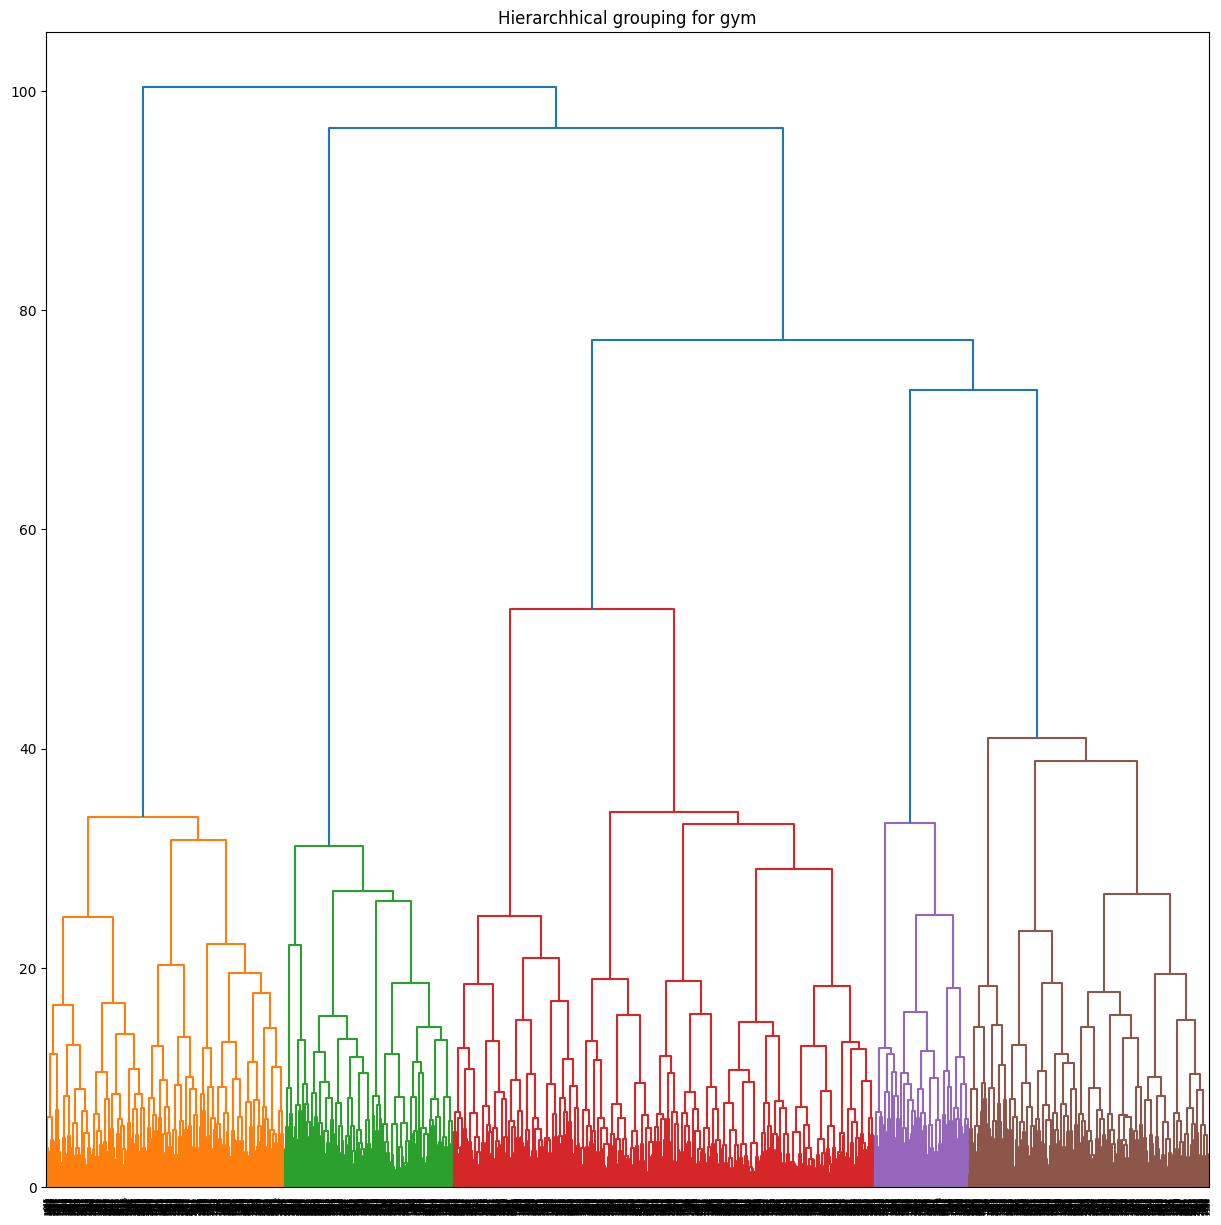

In [117]:
#ploting the dendrogram

plt.figure(figsize=[15,15])
dendrogram(linked, orientation='top')
plt.title('Hierarchhical grouping for gym')
plt.show()

- Based on the 5 colors from the dendrogram I'm going to use a model with 5 clusters in the following steps.

#### 4.2 Training the group with K-means

In [118]:
#set the function to render paired feature graphs for groupings
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=[10,10])
    sns.scatterplot(x=x_name, y=y_name, hue=cluster_name, data=df, palette='Paired')
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [119]:
#standardizing the data
sc = StandardScaler()
X_sc = sc.fit_transform(gym_churn)

In [120]:
#seting the k-means model with 5 clusters
km = KMeans(n_clusters = 5)

#predict the clusters for observations
labels = km.fit_predict(X_sc)

In [121]:
#storing the grouping labels in our dataframe
gym_churn['cluster_churn'] = labels

In [122]:
#obtaining the statistics of mean values of the charcteristics per cluster
gym_churn.groupby(['cluster_churn']).mean() 

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_churn,,,,,,,,,,,,,,
0,0.500000,0.000000,0.457565,0.070111,0.918819,2.134686,0.210332,28.503690,131.910726,2.014760,2.732472,1.678386,1.486627,0.452030
1,0.522876,0.993464,0.165266,0.045752,0.903828,2.605976,0.445378,30.060691,157.590056,2.443511,4.697479,1.877388,1.880049,0.001867
2,0.497710,0.977099,0.885496,0.790840,0.897710,3.558779,0.465649,30.058015,155.772287,3.268702,4.951145,2.338678,2.339196,0.006107
3,0.513109,1.000000,0.330836,0.219725,0.900125,1.612984,0.292135,26.940075,114.048767,1.563046,0.975031,1.472717,1.045748,0.992509
4,0.508056,0.940924,0.727175,0.486574,0.901182,11.980666,0.557465,29.888292,165.538601,10.944146,4.686359,2.023878,2.018373,0.016112


- Clients from the clusters 2, 3 and 4 have the least chance of churn in comparisson to the cluster 2. We can also see that the clients from cluster 0 are slowly leaving so we must check what is going on.

- The main points we can see on cluster 2 (churn of 0,9987) are, having a smaller contract period, they have a low participation in group visits, in average they are 26 years old, they spend the least amount in average additional charges, they have few months until the contract ends (about 1,56 months). The lifetime is short and they have the least avg_class_frequency in the current month.

- When we think about cluster 0 (churn of 0,4693), some points need attention:
    - most of them did not subscribe because a friend indicated
    - they have a low participation in group visits
    - their lifetime is the second smallest compared to group 2

In [123]:
print(gym_churn.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn', 'cluster_churn'],
      dtype='object')


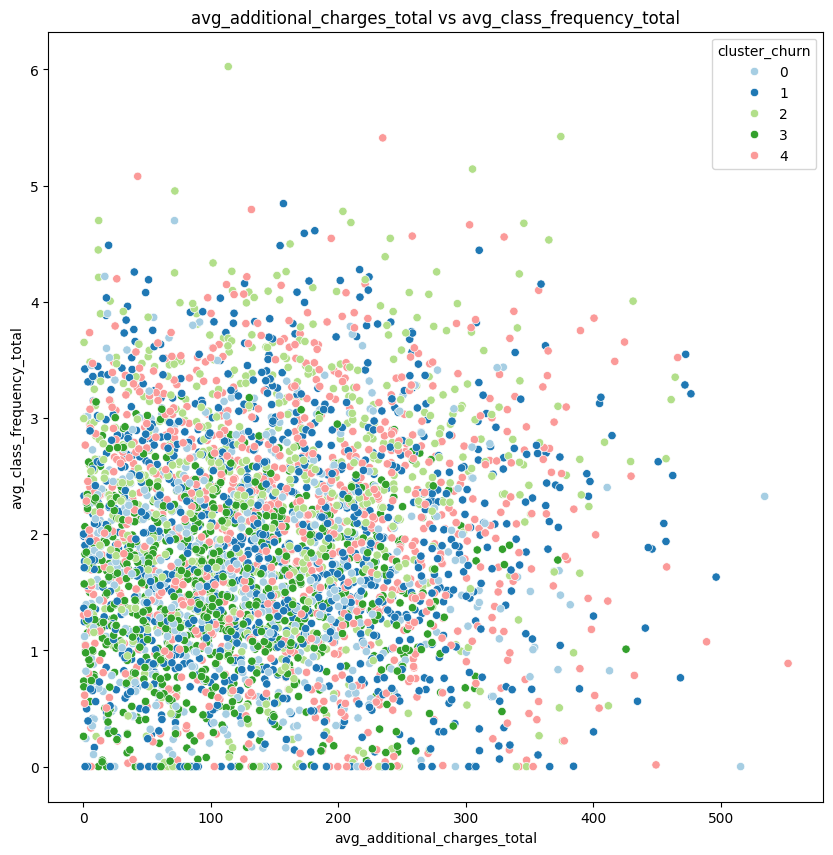

In [124]:
#render the graphic for the paired characteristics
show_clusters_on_plot(gym_churn,'avg_additional_charges_total','avg_class_frequency_total','cluster_churn')

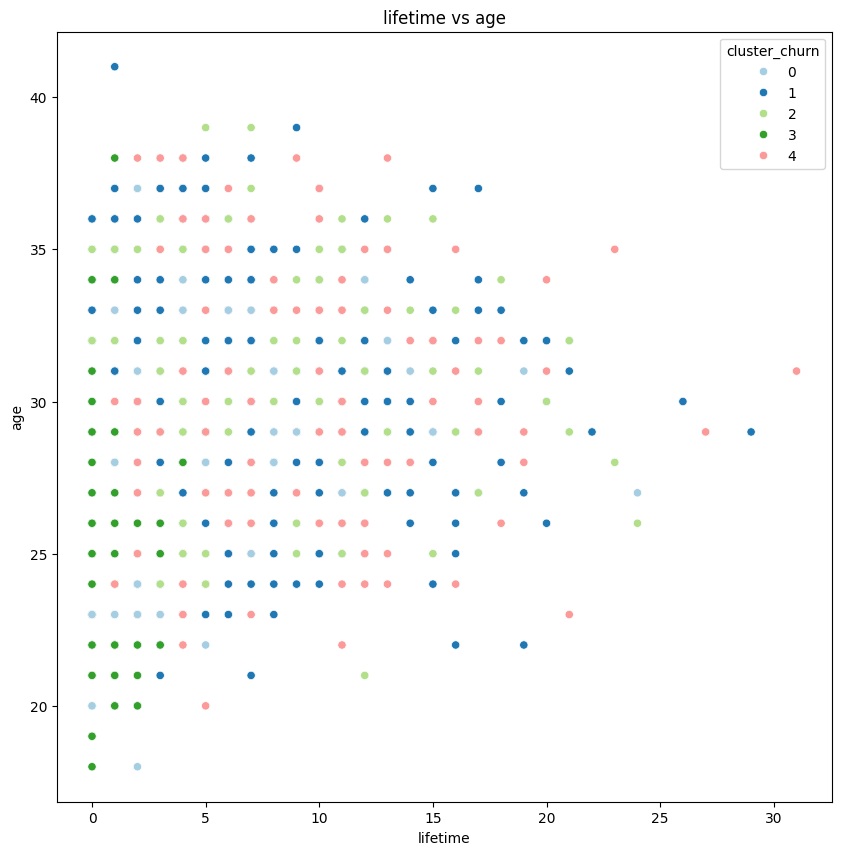

In [125]:
#render the graphic for the paired characteristics
show_clusters_on_plot(gym_churn,'lifetime','age','cluster_churn')

    Faça distribuições de características para os agrupamentos. Você notou alguma coisa?

## Step 5 - Draw conclusions and make basic recommendations about working with clients